## **1. Random Test Flat-Field Correction on a 12-bit Image**

### Explanation of the Flat-Field Correction Code

This code processes a random TIFF image from a specified folder to apply flat-field correction. Flat-field correction is essential in image processing to remove pixel intensity variations caused by the sensor or lighting inconsistencies. Here's a breakdown of the steps involved:

1. **Functions Defined**:
   - `get_tiff_files`: Retrieves a list of TIFF files from the folder containing the images to be processed.
   - `flat_field_correction`: Performs the flat-field correction using the selected TIFF image, a previously generated background image, and an optional dark frame (or a zero matrix if the dark frame is missing).

2. **Process Overview**:
   - A random TIFF image is chosen from the specified folder.
   - The background image (flat-field) and dark frame (optional) are loaded from the base directory.
   - If no dark frame is found, a zero matrix is used instead.
   - All images are 12-bit, and they are scaled to 16-bit values to preserve the data range for further calculations.
   - The correction follows the formula: 
     \[
     C = (R - D) \times G
     \]
     Where:
     - `R` is the raw image.
     - `D` is the dark frame.
     - `G` is the gain calculated as the mean pixel value of the background image divided by the background image (after dark frame subtraction).
   - The formula ensures that pixel intensities are corrected for uneven illumination and sensor shading.

3. **Image Display**:
   - The code shows four images:
     - The original raw image (16-bit scaled).
     - The flat-field (background) image.
     - The dark frame (or zero matrix).
     - The corrected image after applying the flat-field correction.
     
4. **Code Use**:
   - This code is designed to run in a JupyterLab environment, where the corrected image and the intermediate steps are displayed inline for analysis.
   
This flat-field correction process helps to enhance the quality of the images by reducing noise and ensuring uniformity across the image.


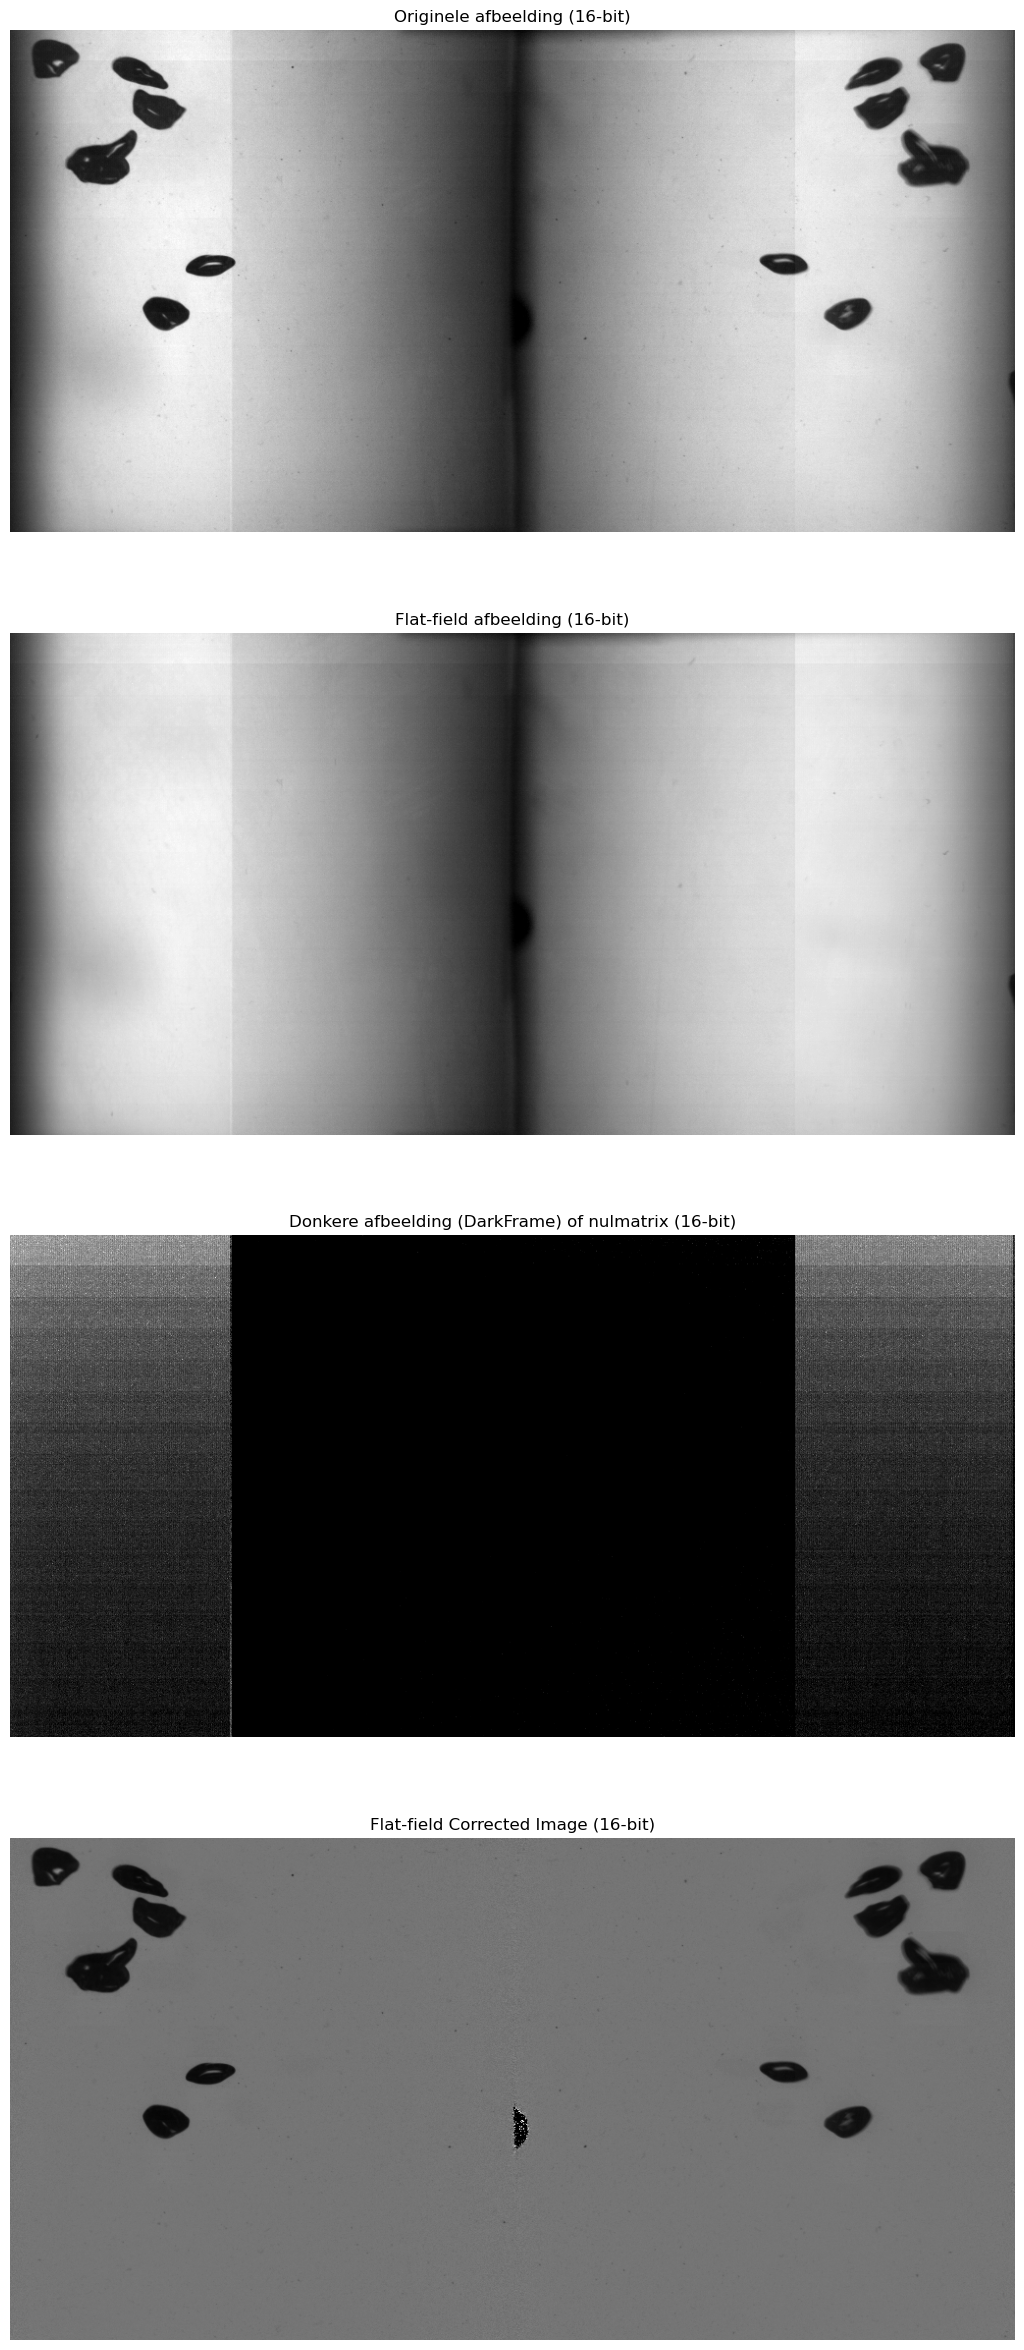

In [25]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import random

# Function to retrieve TIFF files
def get_tiff_files(tiff_folder):
    return [f for f in os.listdir(tiff_folder) if f.endswith('.tif')]

# Function to perform flat-field correction for 12-bit images
def flat_field_correction(tiff_folder, base_directory):
    tiff_files = get_tiff_files(tiff_folder)
    
    if not tiff_files:
        print("Geen TIFF-bestanden gevonden in de map.")
        return
    
    # Choose a random image
    random_image_file = random.choice(tiff_files)
    random_image_path = os.path.join(tiff_folder, random_image_file)
    
    # Path to the previously generated background image in the base_directory
    background_image_path = os.path.join(base_directory, "BackgroundImage.tif")
    dark_frame_path = os.path.join(base_directory, "DarkFrame.tif")
    
    # Read the random image and the flat-field image (all 12-bit)
    random_image = tiff.imread(random_image_path)
    background_image = tiff.imread(background_image_path)
    
    # If the dark frame doesn't exist, create a zero matrix with the same shape as the image
    if os.path.exists(dark_frame_path):
        dark_frame = tiff.imread(dark_frame_path)
    else:
        print("Dark frame niet gevonden. Gebruik een nulmatrix.")
        dark_frame = np.zeros_like(random_image, dtype=np.uint16)
    
    # Convert the 12-bit images (max value 4095) to 16-bit (max value 65535)
    random_image_16bit = (random_image.astype(np.uint32) * 16).astype(np.uint16)
    background_image_16bit = (background_image.astype(np.uint32) * 16).astype(np.uint16)
    dark_frame_16bit = (dark_frame.astype(np.uint32) * 16).astype(np.uint16)
    
    # Perform flat-field correction based on the formula C = (R - D) * G
    # where G = m / (F - D)
    epsilon = 1e-5  # Small value to avoid division by zero
    
    # Subtract dark frame from raw and flat-field images, ensure no negative values
    raw_minus_dark = np.clip((random_image_16bit - dark_frame_16bit), 0, None).astype(np.float32)
    background_minus_dark = np.clip((background_image_16bit - dark_frame_16bit), 0, None).astype(np.float32)
    
    # Calculate gain G
    m = np.mean(background_minus_dark)
    gain = m / (background_minus_dark + epsilon)
    
    # Apply flat-field correction
    corrected_image = np.clip(raw_minus_dark * gain, 0, 65535).astype(np.uint16)
    
    # Display the original image, the flat-field image, the dark frame (or zero matrix), and the corrected result
    fig, ax = plt.subplots(4, 1, figsize=(50, 30))
    ax[0].imshow(random_image_16bit, cmap='gray')
    ax[0].set_title("Originele afbeelding (16-bit)")
    ax[0].axis('off')
    
    ax[1].imshow(background_image_16bit, cmap='gray')
    ax[1].set_title("Flat-field afbeelding (16-bit)")
    ax[1].axis('off')
    
    ax[2].imshow(dark_frame_16bit, cmap='gray')
    ax[2].set_title("Donkere afbeelding (DarkFrame) of nulmatrix (16-bit)")
    ax[2].axis('off')
    
    ax[3].imshow(corrected_image, cmap='gray')
    ax[3].set_title("Flat-field Corrected Image (16-bit)")
    ax[3].axis('off')
    
    plt.show()

# Define the path to the folder with TIFF files
base_directory = os.getcwd()
tiff_folder = os.path.join(base_directory, "Temporary copy of original recording")

# Perform flat-field correction
flat_field_correction(tiff_folder, base_directory)



## **2. Batch Processing of TIFF Images with Flat-Field Correction and 12-bit Conversion**

### Purpose:
This code processes multiple folders containing TIFF images by applying **flat-field correction** and converting the images from 16-bit to 12-bit TIFF format using **ImageMagick**. It automatically processes all folders in the base directory that start with 'Fxxxxxx-Fxxxxxx', which are assumed to contain original TIFF images.

### Key Features:
1. **Flat-Field Correction**:
   - Each TIFF image is corrected by subtracting a dark frame and adjusting for uneven illumination using a pre-calculated background (flat-field) image.
   - The formula used for correction is:
     \[
     \text{Corrected Image} = (\text{Raw Image} - \text{Dark Frame}) \times \frac{m}{\text{Background Image} - \text{Dark Frame}}
     \]
     where \( m \) is the mean of the background image after dark frame subtraction.

2. **Batch Processing**:
   - The code identifies all folders with names starting with 'Fxxxxxx-Fxxxxxx', processes the TIFF images inside, and saves the corrected images in a subfolder named `Flat-field corrected images Fxxxxxx-Fxxxxxx`.
   - This ensures the flat-field correction is applied to all images inside each folder.

3. **ImageMagick Conversion**:
   - After processing, each image is temporarily saved as a 16-bit TIFF, and then ImageMagick is used to convert the 16-bit image to 12-bit TIFF format. This step optimizes storage while maintaining image quality.

4. **Automation**:
   - The code automates the flat-field correction and conversion process for multiple folders, streamlining the workflow for large datasets by processing them in a batch.

### Explanation of Process:
1. **TIFF File Handling**: 
   - The code retrieves TIFF files from folders named 'Fxxxxxx-Fxxxxxx'. It reads the raw images, a background (flat-field) image, and a dark frame (if available).
   
2. **Flat-Field Correction**: 
   - The raw images are corrected by subtracting the dark frame, and the resulting image is scaled by the calculated gain to correct for lighting and sensor imperfections.

3. **Image Conversion**: 
   - The corrected images are first saved as 16-bit TIFF files temporarily, and then ImageMagick is used to convert them back to 12-bit TIFF for efficient storage and compatibility.

4. **Batch Folder Processing**: 
   - The code processes every folder starting with 'Fxxxxxx-Fxxxxxx' in the base directory, automatically applying the correction and conversion to all TIFF images inside.

### Output:
- Each processed folder will contain a new subfolder named `Flat-field corrected images Fxxxxxx-Fxxxxxx`, where the corrected and converted TIFF files are saved.


In [27]:
import os
import numpy as np
import tifffile as tiff
import subprocess

# Function to retrieve TIFF files from a specified folder
def get_tiff_files(folder_path):
    return sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

# Function to apply flat-field correction, save as a 16-bit image temporarily, and convert to 12-bit using ImageMagick
def process_and_save_images(tiff_folder, background_image, dark_frame, output_folder):
    tiff_files = get_tiff_files(tiff_folder)

    if not tiff_files:
        print(f"Geen TIFF-bestanden gevonden in {tiff_folder}.")
        return
    
    os.makedirs(output_folder, exist_ok=True)

    for tiff_file in tiff_files:
        tiff_path = os.path.join(tiff_folder, tiff_file)
        temp_image_path = os.path.join(output_folder, f"temp_{tiff_file}")
        output_image_path = os.path.join(output_folder, tiff_file)

        # Read the image (12-bit)
        image = tiff.imread(tiff_path)

        # Convert the 12-bit image to 16-bit (scale by 16)
        image_16bit = (image.astype(np.uint32) * 16).astype(np.uint16)
        background_image_16bit = (background_image.astype(np.uint32) * 16).astype(np.uint16)
        dark_frame_16bit = (dark_frame.astype(np.uint32) * 16).astype(np.uint16)

        # Subtract dark frame from the image and background, ensuring no negative values
        raw_minus_dark = np.clip((image_16bit - dark_frame_16bit), 0, None).astype(np.float32)
        background_minus_dark = np.clip((background_image_16bit - dark_frame_16bit), 0, None).astype(np.float32)
        

        # Perform flat-field correction using the formula: Corrected = (Raw - Dark) * Gain
        epsilon = 1e-5  # Small value to avoid division by zero
        m = np.mean(background_minus_dark)
        gain = m / (background_minus_dark + epsilon)
        
        corrected_image_16bit = np.clip(raw_minus_dark * gain, 0, 65535).astype(np.uint16)

        # Save the image as a 16-bit TIFF temporarily
        tiff.imwrite(temp_image_path, corrected_image_16bit)
        
        # Now convert the 16-bit image to 12-bit using ImageMagick
        command = rf'"C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe" "{temp_image_path}" -depth 12 -define tiff:rows-per-strip=5 -units PixelsPerInch -density 96 "{output_image_path}"'
        
        # Execute the command and capture the output and errors
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        stdout, stderr = process.communicate()

        # Remove the temporary image
        if os.path.exists(temp_image_path):
            os.remove(temp_image_path)

# Function to process all Fxxxxxx-Fxxxxxx folders
def process_all_folders(base_directory, background_image_path, dark_frame_path):
    folders = [f for f in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, f)) and f.startswith('F') and '-' in f]

    # Read the background image and dark frame
    background_image = tiff.imread(background_image_path).astype(np.uint16)
    
    if os.path.exists(dark_frame_path):
        dark_frame = tiff.imread(dark_frame_path)
    else:
        print("Dark frame niet gevonden. Gebruik een nulmatrix.")
        dark_frame = np.zeros_like(background_image, dtype=np.uint16)

    for folder in folders:
        original_images_folder = os.path.join(base_directory, folder, f"Original images {folder}")
        output_folder = os.path.join(base_directory, folder, f"Flat-field corrected images {folder}")

        if os.path.exists(original_images_folder):
            print(f"Processing folder: {original_images_folder}")

            # Apply flat-field correction and save images
            process_and_save_images(original_images_folder, background_image, dark_frame, output_folder)

        else:
            print(f"Map {original_images_folder} bestaat niet.")

# Define the path to the folder with the background image
base_directory = os.getcwd()
background_image_path = os.path.join(base_directory, "BackgroundImage.tif")
dark_frame_path = os.path.join(base_directory, "DarkFrame.tif")

# Process all Fxxxxxx-Fxxxxxx folders
process_all_folders(base_directory, background_image_path, dark_frame_path)


Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\13 - Data Analysis codes\02 - DepthMapWithShapeRepair\F000241-F000270\Original images F000241-F000270
Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\13 - Data Analysis codes\02 - DepthMapWithShapeRepair\F001941-F001970\Original images F001941-F001970
Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\13 - Data Analysis codes\02 - DepthMapWithShapeRepair\F002621-F002660\Original images F002621-F002660
